# NYCU Machine learning HW2 : Linear Discriminant Analysis 
## Written By 313511068 練鈞揚

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from pathlib import Path
from itertools import combinations
from abc import ABC, abstractmethod
from rich import print
from sklearn.metrics import roc_curve, auc

In [208]:
# setting
np.set_printoptions(precision=2, suppress=True)

In [209]:
LABEL = ["Setosa" , "Versicolor" , "Virginica" ]

COLOR_1 = dict(zip(LABEL, ["red" , "green" , "blue"]))
COLOR_2 = dict(zip(LABEL, ["pink" , "yellow" , "orange"]))
COLOR_3 = dict(zip(LABEL, ["brown", "lightgreen", "navy", "magenta"]))
COLOR_4 = dict(zip(LABEL, ["teal", "gold", "violet", "coral"]))

COLOR_SELECT = {
    "before": {
        "train":COLOR_1,
        "test":COLOR_2,
    },
    "after": {
        "train":COLOR_3,
        "test":COLOR_4,
    }
}

COLUMN_NAME = ["Sepal length", "Sepal width" , "Petal length" , "Petal width" , "Label"]
TRAIN_DATA_SIZE = 25
ASSETS = "./assets"

In [210]:
assets_folder = Path(ASSETS)
assets_folder.mkdir(parents=True, exist_ok=True) 

In [211]:
def load_iris_file(with_name:bool=False)->pd.DataFrame:
    df = pd.read_fwf("./iris.txt")
    
    df_new = pd.DataFrame({k:[v] for k ,v in zip(COLUMN_NAME , df.columns)},dtype=float)
    df.columns = COLUMN_NAME
    df_new = pd.concat([df_new, df], axis=0).reset_index().drop(columns=["index"])
    
    if not with_name:
        return df_new
    
    df_with_name = df_new.copy()
    
    df_with_name["Label"] = df_with_name["Label"].apply(lambda x : LABEL[int(x)-1])
    
    return df_with_name

In [212]:
df = load_iris_file(with_name=True)
df

,Sepal length,Sepal width,Petal length,Petal width,Label
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [213]:
POSITIVE_CLASS ,NEGATIVE_CLASS= "Versicolor" , "Virginica"

## Part 2

In [214]:

def build_dataset(df_in:pd.DataFrame, select_column:list[str] = ["Petal length", "Petal width"], positive:str = POSITIVE_CLASS, negative:str = NEGATIVE_CLASS) -> dict:
    if "Label" not in select_column:
        select_column += ["Label"]
    
    df = df_in[select_column].copy()
    positive_training_data = df[df["Label"]==positive].copy()
    negative_training_data = df[df["Label"]==negative].copy()
    
    before_cross_train = [positive_training_data[:TRAIN_DATA_SIZE], negative_training_data[:TRAIN_DATA_SIZE]]
    before_cross_test = [positive_training_data[TRAIN_DATA_SIZE:] , negative_training_data[TRAIN_DATA_SIZE:]]

    def merge_dataset(df_list:list[pd.DataFrame]) -> pd.DataFrame:
        return pd.concat(df_list).reset_index().drop(columns=["index"])
    
    before_cross_train = merge_dataset(before_cross_train)
    before_cross_test = merge_dataset(before_cross_test)
    
    before_cross_dataset = {
        "train":before_cross_train,
        "test":before_cross_test,
    }
    
    after_cross_dataset = {
        "train":before_cross_test,
        "test":before_cross_train,
    }
        
    return {
        "before": before_cross_dataset , 
        "after":after_cross_dataset
    }

In [215]:
dataset = build_dataset(df)
dataset

{'before': {'train':     Petal length  Petal width       Label
  0            4.7          1.4  Versicolor
  1            4.5          1.5  Versicolor
  2            4.9          1.5  Versicolor
  3            4.0          1.3  Versicolor
  4            4.6          1.5  Versicolor
  5            4.5          1.3  Versicolor
  6            4.7          1.6  Versicolor
  7            3.3          1.0  Versicolor
  8            4.6          1.3  Versicolor
  9            3.9          1.4  Versicolor
  10           3.5          1.0  Versicolor
  11           4.2          1.5  Versicolor
  12           4.0          1.0  Versicolor
  13           4.7          1.4  Versicolor
  14           3.6          1.3  Versicolor
  15           4.4          1.4  Versicolor
  16           4.5          1.5  Versicolor
  17           4.1          1.0  Versicolor
  18           4.5          1.5  Versicolor
  19           3.9          1.1  Versicolor
  20           4.8          1.8  Versicolor
  21         

In [216]:
# check the data
assert all(dataset["before"]["train"] == dataset["after"]["test"])
assert all(dataset["before"]["test"] == dataset["after"]["train"])

In [217]:
def plot_data(dataset_in:dict,states:list[str],select_ds:list[str],axis_label:list[str] , func_dict:dict[str, list[dict]]=None , filename:str=None):
    plt.clf()
    if len(axis_label) > 2 :
        raise NotImplementedError
    
    label_lst = dataset_in[states[0]][select_ds[0]]["Label"].unique()
    
    # Step 1: Plot the points based on 'Label'
    for state in states:
        for select in select_ds:
            color_dict = COLOR_SELECT[state][select]
            df_select = dataset_in[state][select]
    
            for label, color in color_dict.items():
                if label not in label_lst:
                    continue
                
                # Filter the DataFrame for each label and plot
                subset = df_select[df_select['Label'] == label]
                plt.scatter(
                    subset[axis_label[0]], 
                    subset[axis_label[1]], 
                    color=color, 
                    label="_".join([label , state, select])
                )
    
    
    df_in = pd.concat([dataset_in[state][select] for select in select_ds for state in states])
    # plot the line
    if func_dict is not None:
        x_min , x_max = df_in[axis_label[0]].min(), df_in[axis_label[0]].max()
        x_values = np.arange(x_min , x_max,0.1)
        
        for state , funcs in func_dict.items():
            for func in funcs:
                w =func["w"]
                b = func["b"]
                y_values = -(w[0] * x_values + b) / w[1]
                plt.plot(x_values, y_values, label=f'{state}: D(x) = {w}x + {b:.1f}')
    
    # Step 2: Customize the plot
    plt.title(f'{"+".join(states)}:{axis_label[0]} x {axis_label[1]}')
    plt.xlabel(f'{axis_label[0]} Axis')
    plt.ylabel(f'{axis_label[1]} Axis')
    plt.legend()  # Show legend for labels

    if filename is not None:
        plt.savefig(filename)
        print(f"save image : {filename}")
        
    
    # Step 3: Show the plot
    plt.show()
    return 

save image : assets/data_point.png

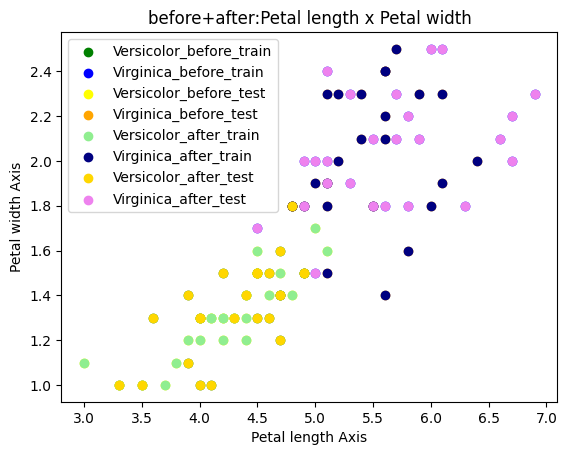

In [218]:
plot_data(
    dataset,
    states=["before" , "after"],
    select_ds=["train","test"],
    axis_label=["Petal length" ,"Petal width"],
    filename=assets_folder.joinpath("data_point.png")
)

In [219]:
class LdaTestAbc(ABC):
    
    @abstractmethod
    def fit(self, data_in:pd.DataFrame) -> None:
        raise NotImplementedError
    
    @abstractmethod
    def acc(self,x_df:pd.DataFrame)-> float:
        raise NotImplementedError
    
    @abstractmethod
    def func(self) -> dict | list:
        raise NotImplementedError
    
    @abstractmethod
    def to_df_record(self) -> dict:
        raise NotImplementedError

In [220]:
class Lda(LdaTestAbc):
    def __init__(self , positive_class:str , negative_class:str,  c1:int = 1, c2:int = 1):
        self._w :np.ndarray = None
        self._cov_matrix :np.ndarray= None
        self._b = None
        
        self._positive_class :str = positive_class 
        self._negative_class :str = negative_class
        self._display_class = [self._negative_class ,self._positive_class]
        self._c1 = c1
        self._c2 = c2
        return
    
    @property
    def w(self)->np.ndarray:
        return self._w
    
    @property
    def b(self):
        return self._b
    
    @property
    def c(self):
        return self._c1 , self._c2
    
    @property
    def cov_matrix(self)->np.ndarray:
        return self._cov_matrix
    
    @staticmethod
    def _build_mean_and_cov(data_in: np.ndarray):
        mean  = np.mean(data_in , axis=0)
        cov = np.cov(data_in.T)
        return mean , cov
    
    def fit(self , data_in:pd.DataFrame)->None:
        positive_data = data_in[data_in["Label"] == self._positive_class]
        negative_data = data_in[data_in["Label"] == self._negative_class]
        
        positive_data = positive_data.drop(columns=["Label"]).to_numpy()
        negative_data = negative_data.drop(columns=["Label"]).to_numpy()
        
        positive_mean , positive_cov = Lda._build_mean_and_cov(positive_data)
        negative_mean , negative_cov = Lda._build_mean_and_cov(negative_data)
        
        positive_len , negative_len = len(positive_data) , len(negative_data)
        
        total = positive_len + negative_len
        p1 , p2 = positive_len / total, negative_len / total
        
        # cov matrix
        self._cov_matrix = p1 * positive_cov + p2 * negative_cov
        
        inv_cov = np.linalg.pinv(self._cov_matrix)
        
        # weight
        self._w = (positive_mean - negative_mean).T @ inv_cov
        
        # b
        self._b = -(1/2)*(positive_mean - negative_mean).T @ inv_cov @ (positive_mean + negative_mean) - np.log((self._c1*p2)/ (self._c2*p1))
        
        return  
    
    def predict(self, x:np.ndarray) -> np.ndarray:
        return self._w.T @ x + self._b
    
    def predict_with_df(self, x_df:pd.DataFrame) -> np.ndarray:
        np_array = x_df.drop(columns=["Label"]).to_numpy().T
        result = self.predict(np_array)
        arr_item = np.array([self._display_class[int(item)] for item in result > 0])
        return arr_item
    
    def acc(self , x_df: pd.DataFrame)-> float:    
        predict_out = self.predict_with_df(x_df)
        true_label = x_df["Label"].to_numpy()
        
        return np.mean(predict_out == true_label)
    
    def acc_roc_aur(self,x_df: pd.DataFrame , mapping_dict:dict)-> dict:
        predict_out = self.predict_with_df(x_df)
        true_label = x_df["Label"].to_numpy()
        
        acc = np.mean(predict_out == true_label)
        
        predict_out_num = np.vectorize(mapping_dict.get)(predict_out)
        true_label_num = np.vectorize(mapping_dict.get)(true_label)
        
        fpr, tpr, thresholds = roc_curve(true_label_num, predict_out_num)
        
        roc_auc = auc(fpr, tpr)
        
        return {
            "acc":acc,
            "roc":(fpr, tpr),
            "aur":roc_auc,
        }
        
    
    def func(self) -> dict:
        return {"w":self._w , "b":self._b}
    
    def to_df_record(self)->dict:
        return {
            "Name": f"Pos:{self._positive_class},Neg:{self._negative_class}", 
            "Weight Vector":f"[{','.join(map(lambda x : f'{x:.2f}',  self._w))}]", 
            "Bias": f"{self._b:.2f}",
        }
    
    def __call__(self,x:np.ndarray) -> np.ndarray:
        return self.predict(x)
    
    def __repr__(self) -> str:
        if self._w is None or self._b is None or self._cov_matrix is None:
            return "Model is not fitted"
        
        return f"Pos:{self._positive_class}, Neg: {self._negative_class}, W : {self._w} B : {self._b:.2f} Cov:{self._cov_matrix}"
    
    def __str__(self) -> str:
        if self._w is None or self._b is None or self._cov_matrix is None:
            return "Model is not fitted"
        
        return f"Pos:{self._positive_class}, Neg: {self._negative_class}\nW : {self._w}\nB : {self._b:.2f}\nCov:\n{self._cov_matrix}"
        

In [221]:
def test_model(model_in :LdaTestAbc , dataset_in:dict) -> tuple[str, dict, pd.DataFrame]:
    
    def run_by_dataset(dataset_choose:str) -> tuple:
        model_in.fit(dataset_in[dataset_choose]["train"])
        out_str = f'{dataset_choose}:\n{str(model_in)}\n'
        
        acc = model_in.acc(dataset_in[dataset_choose]["test"])
        out_str += f"Acc :{acc*100:.2f}%\n\n"
        
        model_func, model_record = model_in.func(), model_in.to_df_record()
        
        model_record["Acc"] = f"Acc :{acc*100:.2f}%"
        
        if not isinstance(model_func,list):
            model_func = [model_func]
        
        return out_str , acc , model_func, model_record
    
    before_out, before_acc, before_func, before_model_record = run_by_dataset("before")
    after_out, after_acc, after_func, after_model_record = run_by_dataset("after")
    
    out_res_str = before_out + after_out
    avg_acc = (before_acc + after_acc) / 2
    
    out_res_str += f"Avg acc :{avg_acc*100:.2f}%"
    
    before_model_record["Name"] = f'(Before) {before_model_record["Name"]}'
    after_model_record["Name"] = f'(After) {after_model_record["Name"]}'
    
    return out_res_str , {"before":before_func , "after":after_func} , pd.DataFrame([before_model_record,after_model_record])

In [222]:
def analysis_model(task_name:str, model_in :LdaTestAbc, dataset_in:dict , folder:str | Path)->None:
    print("==============================================")
    print(task_name)
    test_model_detail , test_model_func, test_model_record_df = test_model(model_in=model_in,dataset_in=dataset_in)
    print(test_model_detail)
    
    folder :Path = Path(folder)
    folder.mkdir(parents=True, exist_ok=True)  
    
    plot_data(
        dataset_in,
        states=["before" ], 
        select_ds=["train", "test"], 
        axis_label=["Petal length" ,"Petal width"],
        func_dict={"before":test_model_func["before"]},
        filename=folder.joinpath("before.jpg"),
    )
    
    plot_data(
        dataset_in,
        states=["after" ], 
        select_ds=["train", "test"], 
        axis_label=["Petal length" ,"Petal width"],
        func_dict={"after":test_model_func["after"]},
        filename=folder.joinpath("after.jpg"),
    )

    plot_data(
        dataset_in,
        states=["before" , "after"], 
        select_ds=["train", "test"], 
        axis_label=["Petal length" ,"Petal width"],
        func_dict=test_model_func,
        filename=folder.joinpath("all.jpg"),
    )
    
    print("Markdown")
    print(test_model_record_df.to_markdown())
    
    print("==============================================")
    
    return 

In [223]:
lda_model = Lda(positive_class=POSITIVE_CLASS , negative_class=NEGATIVE_CLASS)

==============================================

two class

before:
Pos:Versicolor, Neg: Virginica
W : [ -2.09 -10.46]
B : 28.10
Cov:
[[0.31 0.07]
 [0.07 0.05]]
Acc :94.00%

after:
Pos:Versicolor, Neg: Virginica
W : [-3.73 -7.85]
B : 31.08
Cov:
[[0.22 0.06]
 [0.06 0.06]]
Acc :94.00%

Avg acc :94.00%

save image : assets/part2/before.jpg

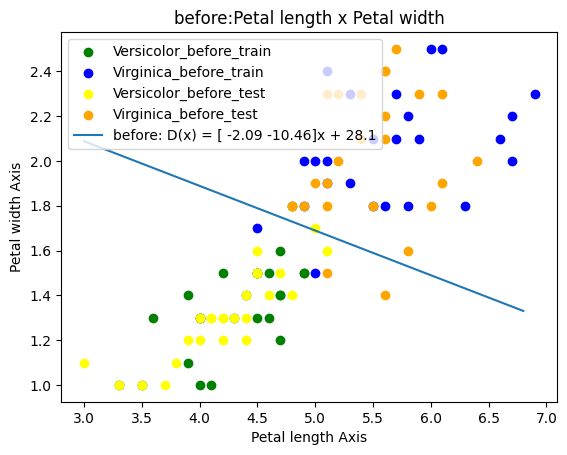

save image : assets/part2/after.jpg

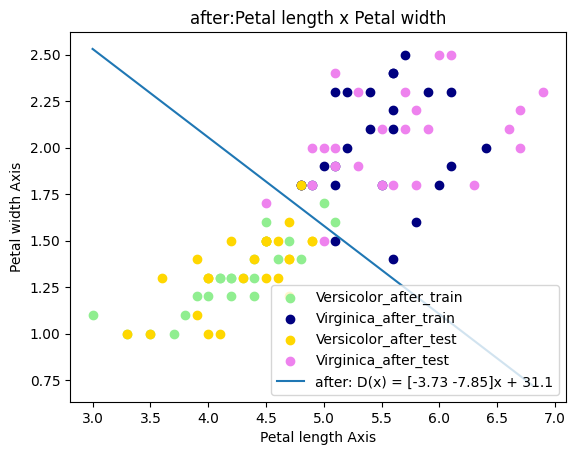

save image : assets/part2/all.jpg

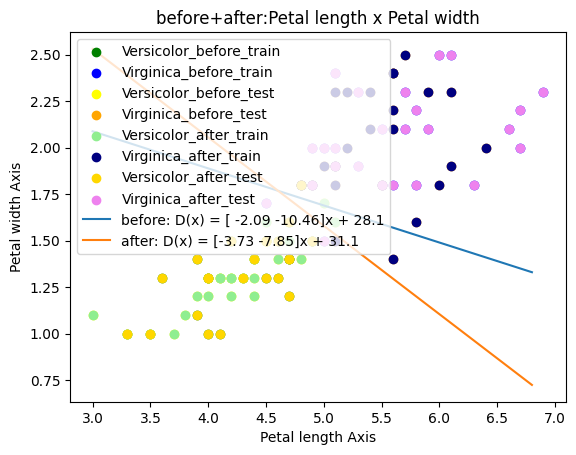

Markdown

|    | Name                                  | Weight Vector   |   Bias | Acc         |
|---:|:--------------------------------------|:----------------|-------:|:------------|
|  0 | (Before) Pos:Versicolor,Neg:Virginica | [-2.09,-10.46]  |  28.1  | Acc :94.00% |
|  1 | (After) Pos:Versicolor,Neg:Virginica  | [-3.73,-7.85]   |  31.08 | Acc :94.00% |

==============================================

In [224]:
analysis_model(
    task_name="two class",
    model_in=lda_model,
    dataset_in=dataset,
    folder=assets_folder.joinpath("part2")
)

## Part 3

In [226]:
def plot_roc_aur(title:str , roc_aur_list:dict[str,dict] , filename:str = None) -> None:
    plt.clf()
    for name , roc_aur_dict in roc_aur_list.items():
        fpr, tpr = roc_aur_dict["roc"]
        roc_auc = roc_aur_dict["aur"]
        plt.plot(fpr, tpr, lw=2, label=f'ROC:({name}) curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random chance)
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{title} (ROC)")
    plt.legend(loc="lower right")
    plt.grid()
    
    if filename is not None:
        plt.savefig(filename)
        print(f"save image : {filename}")
        
    plt.show()
    return 

In [229]:
def run_roc_aur_analysis_term(folder: str | Path):
    part_3_pos , part_3_neg = "Virginica" , "Versicolor"
    part_3_map_label = {"Versicolor":0, "Virginica":1}
    
    part_3_c_combination = [(1, 1) , (1, 10),(10, 1)] 

    folder:Path = Path(folder)
    folder.mkdir(parents=True, exist_ok=True)
    
    part_3_models = {
        f"c1={c1},c2={c2}":Lda(
            positive_class=part_3_pos,
            negative_class=part_3_neg, 
            c1=c1, c2=c2,
        )
        for c1,c2 in part_3_c_combination
    }
    
    part_3_dataset = {
        "Using all feature": build_dataset(df_in=df, select_column=COLUMN_NAME, positive=part_3_pos, negative=part_3_neg),
        "Using 1,2 feature": build_dataset(df_in=df, select_column=COLUMN_NAME[:2], positive=part_3_pos, negative=part_3_neg),
        "Using 3,4 feature": build_dataset(df_in=df, select_column=COLUMN_NAME[2:], positive=part_3_pos, negative=part_3_neg),
    }
    
    # df_record = []
    
    for dataset_name , dataset_use in part_3_dataset.items():
        task = dict()
        for model_name in part_3_models.keys():
            model_item = part_3_models[model_name]
            
            
            model_item.fit(dataset_use["before"]["train"])
            task[f"before_{model_name}" ] = model_item.acc_roc_aur(dataset_use["before"]["test"], mapping_dict=part_3_map_label)
            
            model_item.fit(dataset_use["after"]["train"])
            task[f"after_{model_name}"] = model_item.acc_roc_aur(dataset_use["after"]["test"], mapping_dict=part_3_map_label)
            
        print("==============================================")
        print(f"Dataset: {dataset_name}")   
        print(task)
        filename = folder.joinpath(f"{dataset_name}.jpg")
        plot_roc_aur(
            title=dataset_name,
            roc_aur_list=task,
            filename=filename
        )
        
        df_record = [
            {
                "Model" : model_name,
                "AUR" : item["aur"],
            }   
            for model_name, item in task.items()
        ]
        df_record = pd.DataFrame(df_record)
        print("Markdown")
        print(df_record.to_markdown())
        
        
        print("==============================================")
    
    
        

==============================================

Dataset: Using all feature

{
    'before_c1=1,c2=1': {
        'acc': np.float64(0.94),
        'roc': (array([0.  , 0.04, 1.  ]), array([0.  , 0.92, 1.  ])),
        'aur': np.float64(0.94)
    },
    'after_c1=1,c2=1': {
        'acc': np.float64(0.94),
        'roc': (array([0.  , 0.12, 1.  ]), array([0., 1., 1.])),
        'aur': np.float64(0.94)
    },
    'before_c1=1,c2=10': {
        'acc': np.float64(0.98),
        'roc': (array([0.  , 0.04, 1.  ]), array([0., 1., 1.])),
        'aur': np.float64(0.98)
    },
    'after_c1=1,c2=10': {
        'acc': np.float64(0.94),
        'roc': (array([0.  , 0.12, 1.  ]), array([0., 1., 1.])),
        'aur': np.float64(0.94)
    },
    'before_c1=10,c2=1': {
        'acc': np.float64(0.88),
        'roc': (array([0., 0., 1.]), array([0.  , 0.76, 1.  ])),
        'aur': np.float64(0.88)
    },
    'after_c1=10,c2=1': {
        'acc': np.float64(1.0),
        'roc': (array([0., 0., 1.]), array([0., 1., 1.])),
        'aur': np.float64(1.0)
    }
}

save image : assets/part3/Using all feature.jpg

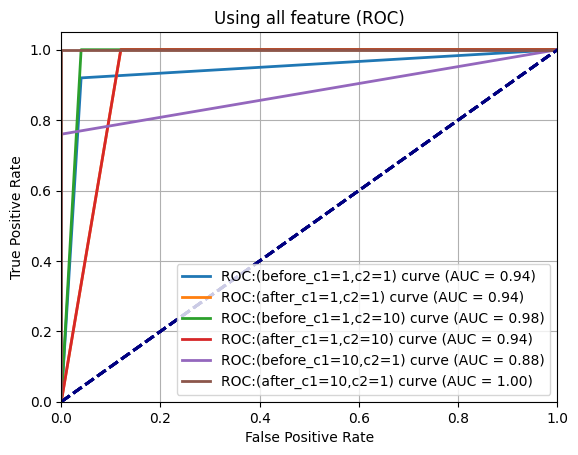

Markdown

|    | Model             |   AUR |
|---:|:------------------|------:|
|  0 | before_c1=1,c2=1  |  0.94 |
|  1 | after_c1=1,c2=1   |  0.94 |
|  2 | before_c1=1,c2=10 |  0.98 |
|  3 | after_c1=1,c2=10  |  0.94 |
|  4 | before_c1=10,c2=1 |  0.88 |
|  5 | after_c1=10,c2=1  |  1    |

==============================================

==============================================

Dataset: Using 1,2 feature

{
    'before_c1=1,c2=1': {
        'acc': np.float64(0.74),
        'roc': (array([0. , 0.2, 1. ]), array([0.  , 0.68, 1.  ])),
        'aur': np.float64(0.7400000000000002)
    },
    'after_c1=1,c2=1': {
        'acc': np.float64(0.7),
        'roc': (array([0.  , 0.32, 1.  ]), array([0.  , 0.72, 1.  ])),
        'aur': np.float64(0.7)
    },
    'before_c1=1,c2=10': {
        'acc': np.float64(0.5),
        'roc': (array([0., 1.]), array([0., 1.])),
        'aur': np.float64(0.5)
    },
    'after_c1=1,c2=10': {
        'acc': np.float64(0.56),
        'roc': (array([0.  , 0.84, 1.  ]), array([0.  , 0.96, 1.  ])),
        'aur': np.float64(0.5599999999999999)
    },
    'before_c1=10,c2=1': {
        'acc': np.float64(0.5),
        'roc': (array([0., 1.]), array([0., 1.])),
        'aur': np.float64(0.5)
    },
    'after_c1=10,c2=1': {
        'acc': np.float64(0.62),
        'roc': (array([0., 0., 1.]), array([0.  , 0.24, 1.  ])),
        'aur': np.float64(0.62)
    }
}

save image : assets/part3/Using 1,2 feature.jpg

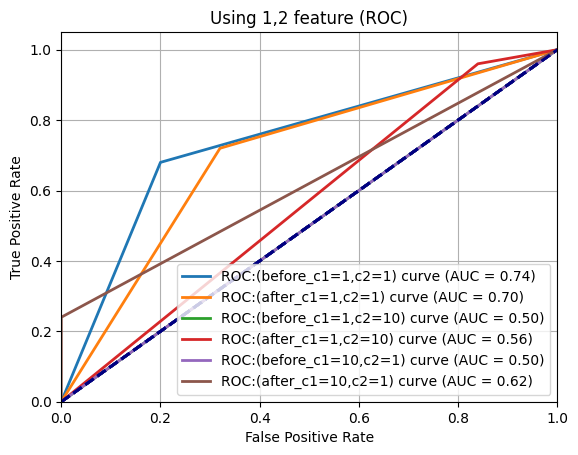

Markdown

|    | Model             |   AUR |
|---:|:------------------|------:|
|  0 | before_c1=1,c2=1  |  0.74 |
|  1 | after_c1=1,c2=1   |  0.7  |
|  2 | before_c1=1,c2=10 |  0.5  |
|  3 | after_c1=1,c2=10  |  0.56 |
|  4 | before_c1=10,c2=1 |  0.5  |
|  5 | after_c1=10,c2=1  |  0.62 |

==============================================

==============================================

Dataset: Using 3,4 feature

{
    'before_c1=1,c2=1': {
        'acc': np.float64(0.94),
        'roc': (array([0.  , 0.04, 1.  ]), array([0.  , 0.92, 1.  ])),
        'aur': np.float64(0.94)
    },
    'after_c1=1,c2=1': {
        'acc': np.float64(0.94),
        'roc': (array([0.  , 0.04, 1.  ]), array([0.  , 0.92, 1.  ])),
        'aur': np.float64(0.94)
    },
    'before_c1=1,c2=10': {
        'acc': np.float64(0.94),
        'roc': (array([0.  , 0.12, 1.  ]), array([0., 1., 1.])),
        'aur': np.float64(0.94)
    },
    'after_c1=1,c2=10': {
        'acc': np.float64(0.9),
        'roc': (array([0. , 0.2, 1. ]), array([0., 1., 1.])),
        'aur': np.float64(0.9)
    },
    'before_c1=10,c2=1': {
        'acc': np.float64(0.82),
        'roc': (array([0., 0., 1.]), array([0.  , 0.64, 1.  ])),
        'aur': np.float64(0.8200000000000001)
    },
    'after_c1=10,c2=1': {
        'acc': np.float64(0.94),
        'roc': (array([0., 0., 1.]), array([0.  , 0.88, 1.  ])),
        'aur': np.float64(0.94)
    }
}

save image : assets/part3/Using 3,4 feature.jpg

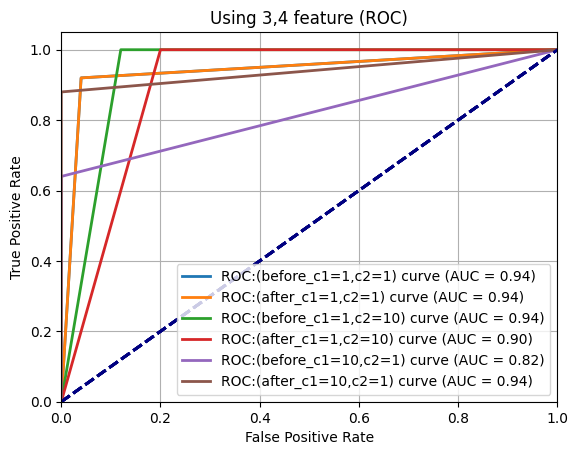

Markdown

|    | Model             |   AUR |
|---:|:------------------|------:|
|  0 | before_c1=1,c2=1  |  0.94 |
|  1 | after_c1=1,c2=1   |  0.94 |
|  2 | before_c1=1,c2=10 |  0.94 |
|  3 | after_c1=1,c2=10  |  0.9  |
|  4 | before_c1=10,c2=1 |  0.82 |
|  5 | after_c1=10,c2=1  |  0.94 |

==============================================

In [230]:
run_roc_aur_analysis_term(folder=assets_folder.joinpath("part3"))

## Part 4

In [76]:
def build_multi_dataset(df_in:pd.DataFrame , class_list:list[str])-> dict:
    df = df_in.drop(columns=["Sepal length",  "Sepal width"])
    
    train_data_lst = [df[df["Label"] == class_name].copy() for class_name in class_list]
    
    before_cross_train = [item_df[:TRAIN_DATA_SIZE] for item_df in train_data_lst]
    before_cross_test = [item_df[TRAIN_DATA_SIZE:] for item_df in train_data_lst]

    def merge_dataset(df_list:list[pd.DataFrame]) -> pd.DataFrame:
        return pd.concat(df_list).reset_index().drop(columns=["index"])
    
    before_cross_train = merge_dataset(before_cross_train)
    before_cross_test = merge_dataset(before_cross_test)
    
    before_cross_dataset = {
        "train":before_cross_train,
        "test":before_cross_test,
    }
    
    after_cross_dataset = {
        "train":before_cross_test,
        "test":before_cross_train,
    }
        
    return {
        "before": before_cross_dataset , 
        "after":after_cross_dataset
    }

In [77]:
multi_dataset = build_multi_dataset(df , class_list=LABEL)
multi_dataset

{'before': {'train':     Petal length  Petal width      Label
  0            1.4          0.2     Setosa
  1            1.4          0.2     Setosa
  2            1.3          0.2     Setosa
  3            1.5          0.2     Setosa
  4            1.4          0.2     Setosa
  ..           ...          ...        ...
  70           5.7          2.3  Virginica
  71           4.9          2.0  Virginica
  72           6.7          2.0  Virginica
  73           4.9          1.8  Virginica
  74           5.7          2.1  Virginica
  
  [75 rows x 3 columns],
  'test':     Petal length  Petal width      Label
  0            1.6          0.2     Setosa
  1            1.6          0.4     Setosa
  2            1.5          0.2     Setosa
  3            1.4          0.2     Setosa
  4            1.6          0.2     Setosa
  ..           ...          ...        ...
  70           5.2          2.3  Virginica
  71           5.0          1.9  Virginica
  72           5.2          2.0  Virginica

In [78]:
# check the data
assert all(multi_dataset["before"]["train"] == multi_dataset["after"]["test"])
assert all(multi_dataset["before"]["test"] == multi_dataset["after"]["train"])

In [240]:
class LdaMultiple(LdaTestAbc):
    def __init__(self , class_list:list[str]):
        self._class_list = class_list
        self._combination_list = list(combinations(class_list, 2))
        self._models = [Lda(pos,neg) for pos , neg  in self._combination_list]        
        return
     
    @property
    def models(self):
        return self._models
    
    def fit(self, data_in:pd.DataFrame)->None:
        for i in range(len(self._models)):
            self._models[i].fit(data_in)
        return 
    
    def predict(self , x_df:pd.DataFrame) -> np.ndarray:
        pred = [item_model.predict_with_df(x_df) for item_model in self._models]
        
        res_np = np.array(pred).T
        
        def get_most_freq_by_row(row):
            unique , counts = np.unique(row , return_counts=True)
            return unique[np.argmax(counts)]
        
        res = np.array([get_most_freq_by_row(row) for row in res_np])
        return res
    
    def acc(self, x_df: pd.DataFrame)-> float:
        pred = self.predict(x_df)
        true_label = x_df["Label"].to_numpy()
   
        return np.mean(pred == true_label)

    def __str__(self):
        class_list_str = f"Class list: {', '.join(self._class_list)}"
        model_str = "\n".join(map(str, self._models))
        return f"{class_list_str}\n{model_str}"
    
    def func(self) -> dict | list:
        return [model_item.func() for model_item in self._models]
    
    def to_df_record(self)->dict:
        weight_list , bias_list = [] , []
        for model in self._models:
            record = model.to_df_record()
            weight_list.append(f"{record['Weight Vector']}")
            bias_list.append(f"{record['Bias']}")
        
        return {
            "Name": ",".join(self._class_list), 
            "Weight Vector":",".join(weight_list), 
            "Bias": ",".join(bias_list),
        }

In [241]:
multi_model = LdaMultiple(LABEL)

==============================================

multi class

before:
Class list: Setosa, Versicolor, Virginica
Pos:Setosa, Neg: Versicolor
W : [-19.67 -15.01]
B : 68.72
Cov:
[[0.12 0.04]
 [0.04 0.03]]
Pos:Setosa, Neg: Virginica
W : [-12.65 -34.96]
B : 84.97
Cov:
[[0.23 0.04]
 [0.04 0.04]]
Pos:Versicolor, Neg: Virginica
W : [ -2.09 -10.46]
B : 28.10
Cov:
[[0.31 0.07]
 [0.07 0.05]]
Acc :96.00%

after:
Class list: Setosa, Versicolor, Virginica
Pos:Setosa, Neg: Versicolor
W : [-14.67 -17.11]
B : 54.87
Cov:
[[0.14 0.04]
 [0.04 0.02]]
Pos:Setosa, Neg: Virginica
W : [-34.15 -23.52]
B : 144.81
Cov:
[[0.11 0.02]
 [0.02 0.05]]
Pos:Versicolor, Neg: Virginica
W : [-3.73 -7.85]
B : 31.08
Cov:
[[0.22 0.06]
 [0.06 0.06]]
Acc :96.00%

Avg acc :96.00%

save image : assets/part4/before.jpg

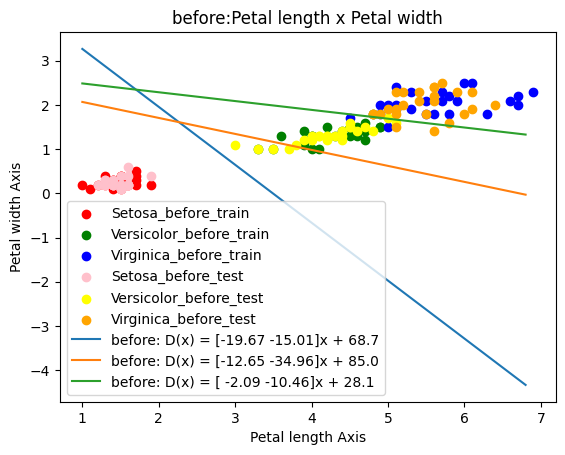

save image : assets/part4/after.jpg

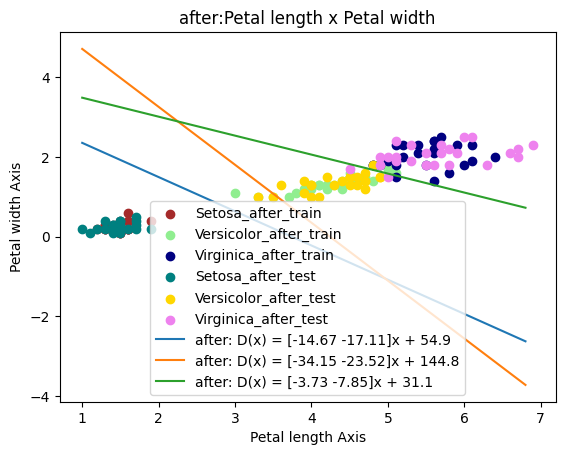

save image : assets/part4/all.jpg

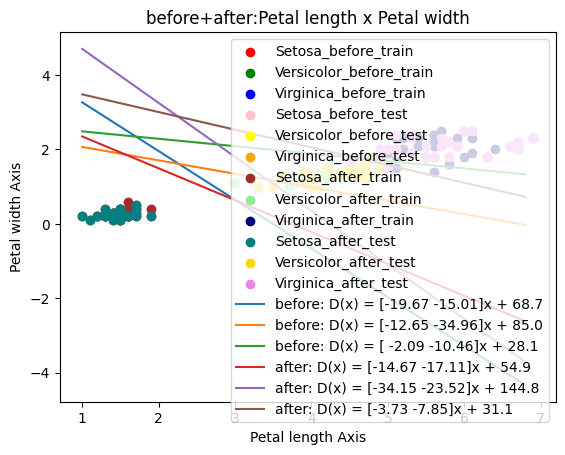

Markdown

|    | Name                                 | Weight Vector                                  | Bias               |
Acc         |
|---:|:-------------------------------------|:-----------------------------------------------|:-------------------|
:------------|
|  0 | (Before) Setosa,Versicolor,Virginica | [-19.67,-15.01],[-12.65,-34.96],[-2.09,-10.46] | 68.72,84.97,28.10  |
Acc :96.00% |
|  1 | (After) Setosa,Versicolor,Virginica  | [-14.67,-17.11],[-34.15,-23.52],[-3.73,-7.85]  | 54.87,144.81,31.08 |
Acc :96.00% |

==============================================

In [242]:
analysis_model(
    task_name="multi class",
    model_in=multi_model,
    dataset_in=multi_dataset,
    folder=assets_folder.joinpath("part4")
)